In [25]:
# # Cài đặt các thư viện cần thiết
# pip install numpy matplotlib opencv-python scikit-image
# !pip install scikit-imageimport sys
# !C:/Users/admin/AppData/Local/Programs/Python/Python313/python.exe -m pip install scikit-image
import sys
print(sys.executable)

c:\Users\admin\AppData\Local\Programs\Python\Python313\python.exe


In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request
from skimage.morphology import footprint_rectangle, dilation
from skimage.morphology import square
from skimage import data
# from google.colab import files

# **1. Tạo hàm để thêm nhiễu xung vào ảnh**

In [27]:
def add_impulse_noise(image, prob_positive, prob_negative):
    """
    Thêm nhiễu xung vào ảnh

    Tham số:
        image: ảnh đầu vào
        prob_positive: xác suất nhiễu dương (điểm trắng)
        prob_negative: xác suất nhiễu âm (điểm đen)

    Trả về:
        ảnh đã thêm nhiễu
    """
    noisy_image = np.copy(image)

    # Tạo mặt nạ ngẫu nhiên cho nhiễu dương
    mask_positive = np.random.random(image.shape) < prob_positive
    # Tạo mặt nạ ngẫu nhiên cho nhiễu âm
    mask_negative = np.random.random(image.shape) < prob_negative

    # Đặt các pixel có mask_positive = True thành giá trị tối đa (255)
    noisy_image[mask_positive] = 255
    # Đặt các pixel có mask_negative = True thành giá trị tối thiểu (0)
    noisy_image[mask_negative] = 0

    return noisy_image

# 2. Triển khai bộ lọc trung vị cơ bản

In [28]:
def median_filter(image, window_size):
    """
    Áp dụng bộ lọc trung vị lên ảnh

    Tham số:
        image: ảnh đầu vào
        window_size: kích thước cửa sổ bộ lọc (phải là số lẻ)

    Trả về:
        ảnh đã lọc
    """
    return cv2.medianBlur(image, window_size)

# 3. Triển khai quy trình phát hiện nhiễu PSM cơ bản

In [29]:
def psm_noise_detection(image, window_size, threshold, iterations):
    """
    Phát hiện nhiễu bằng phương pháp PSM (Progressive Switching Median)

    Tham số:
        image: ảnh đầu vào
        window_size: kích thước cửa sổ bộ lọc trung vị
        threshold: ngưỡng để xác định nhiễu
        iterations: số vòng lặp

    Trả về:
        ảnh cờ nhiễu (1: nhiễu, 0: không nhiễu)
    """
    # Khởi tạo ảnh cờ nhiễu ban đầu
    noise_flag = np.zeros_like(image, dtype=np.uint8)

    # Khởi tạo ảnh cường độ ban đầu
    x = np.copy(image)

    # Lặp qua số vòng lặp đã chỉ định
    for n in range(iterations):
        # Tính toán ảnh trung vị
        median_img = cv2.medianBlur(x, window_size)

        # Cập nhật ảnh cờ nhiễu dựa trên chênh lệch giữa ảnh gốc và ảnh trung vị
        diff = np.abs(x - median_img)
        noise_flag[(diff >= threshold) & (noise_flag == 0)] = 1

        # Cập nhật ảnh cường độ
        x[noise_flag == 1] = median_img[noise_flag == 1]

    return noise_flag

# 4. Triển khai hệ thống 1

In [30]:
def system1_edge_based_detection(image, WE1, WE2, TE, WD1, WD2, TD):
    """
    Hệ thống 1: Phát hiện nhiễu dựa trên ảnh cờ biên

    Tham số:
        image: ảnh đầu vào
        WE1: kích thước cửa sổ nhỏ cho việc tính trung vị vùng biên
        WE2: kích thước cửa sổ lớn cho việc tính trung vị vùng biên
        TE: ngưỡng để xác định vùng biên
        WD1: kích thước cửa sổ nhỏ cho bộ phát hiện nhiễu
        WD2: kích thước cửa sổ lớn cho bộ phát hiện nhiễu
        TD: ngưỡng phát hiện nhiễu

    Trả về:
        ảnh cờ nhiễu (1: nhiễu, 0: không nhiễu)
        ảnh cờ biên (1: vùng biên, 0: vùng phẳng)
    """
    # Tạo ảnh cờ nhiễu với hai kích thước cửa sổ khác nhau
    noise_flag_small = psm_noise_detection(image, WD1, TD, 1)
    noise_flag_large = psm_noise_detection(image, WD2, TD, 1)

    # Khởi tạo các biến cho quá trình tạo ảnh cờ biên
    edge_flag = np.zeros_like(image, dtype=np.uint8)
    y = np.copy(image)
    g = np.copy(noise_flag_large)

    iteration = 0
    max_iterations = 20  # Giới hạn số vòng lặp để tránh vòng lặp vô hạn

    while np.sum(g) > 0 and iteration < max_iterations:
        y_prev = np.copy(y)

        # Tạo ảnh trung vị với cửa sổ nhỏ và lớn
        median_small = cv2.medianBlur(y, WE1)
        median_large = cv2.medianBlur(y, WE2)

        # Tính chênh lệch giữa hai ảnh trung vị
        diff_medians = np.abs(median_small - median_large)

        # Cập nhật edge_flag dựa trên chênh lệch
        edge_flag[(g == 1) & (diff_medians >= TE)] = 1

        # Cập nhật ảnh y dựa trên edge_flag
        y[(g == 1) & (edge_flag == 1)] = median_small[(g == 1) & (edge_flag == 1)]
        y[(g == 1) & (edge_flag == 0)] = median_large[(g == 1) & (edge_flag == 0)]

        # Cập nhật ảnh g
        g[(y != y_prev)] = 0

        iteration += 1

    # Tạo ảnh cờ nhiễu dựa trên ảnh cờ biên
    noise_flag = np.zeros_like(image, dtype=np.uint8)
    noise_flag[edge_flag == 1] = noise_flag_small[edge_flag == 1]
    noise_flag[edge_flag == 0] = noise_flag_large[edge_flag == 0]

    return noise_flag, edge_flag

# 5. Triển khai hệ thống 2

In [31]:
def system2_verification(image, noise_flag, edge_flag, TN, TC, TR):
    """
    Hệ thống 2: Xác minh kết quả phát hiện nhiễu (tối ưu hóa)
    """
    image_int = image.astype(np.int32)
    dilated_edge = dilation(edge_flag, footprint_rectangle((3, 3)))
    verified_noise_flag = np.copy(noise_flag)
    targets = np.where((dilated_edge == 1) & (noise_flag == 1))

    G_half = 255 / 2
    min_dim = min(image.shape) // 2

    for idx in range(len(targets[0])):
        i, j = targets[0][idx], targets[1][idx]
        target_intensity = image_int[i, j]
        compare_points = []

        # Tìm vùng lân cận lớn nhất một lần, sau đó lọc bằng mask
        for n in range(1, min_dim):
            i_min, i_max = max(0, i - n), min(image.shape[0], i + n + 1)
            j_min, j_max = max(0, j - n), min(image.shape[1], j + n + 1)

            window_noise = noise_flag[i_min:i_max, j_min:j_max]
            window_edge = dilated_edge[i_min:i_max, j_min:j_max]
            window_img = image[i_min:i_max, j_min:j_max]

            # Tạo mask: nhiễu, không phải biên, cùng loại (dương/âm), không phải chính nó
            mask = (window_noise == 1) & (window_edge == 0)
            if target_intensity >= G_half:
                mask &= (window_img >= G_half)
            else:
                mask &= (window_img < G_half)
            # Loại bỏ chính nó
            mask[n, n] = False if (i_min <= i < i_max and j_min <= j < j_max) else mask[n, n]

            # Lấy chỉ số các điểm so sánh
            points = np.argwhere(mask)
            for pt in points:
                compare_points.append((i_min + pt[0], j_min + pt[1]))
            if len(compare_points) >= TC:
                break

        if len(compare_points) < TC:
            continue

        # Tính số điểm tương đồng
        compare_vals = image_int[tuple(zip(*compare_points))]
        similar_points = np.sum(np.abs(compare_vals - target_intensity) <= TN)
        R = similar_points / len(compare_points)
        if R < TR:
            verified_noise_flag[i, j] = 0

    return verified_noise_flag

# 6. Kết hợp hai hệ thống

In [48]:
def accurate_noise_detection(image, WE1=5, WE2=7, TE=10, WD1=7, WD2=9, TD=30, TN=10, TC=20, TR=0.8):
    """
    Phương pháp phát hiện nhiễu chính xác được đề xuất trong bài báo

    Tham số:
        image: ảnh đầu vào
        WE1: kích thước cửa sổ nhỏ cho việc tính trung vị vùng biên
        WE2: kích thước cửa sổ lớn cho việc tính trung vị vùng biên
        TE: ngưỡng để xác định vùng biên
        WD1: kích thước cửa sổ nhỏ cho bộ phát hiện nhiễu
        WD2: kích thước cửa sổ lớn cho bộ phát hiện nhiễu
        TD: ngưỡng phát hiện nhiễu
        TN: ngưỡng phạm vi biến đổi của nhiễu xung
        TC: ngưỡng số lượng điểm so sánh tối thiểu
        TR: ngưỡng tỷ lệ điểm tương đồng

    Trả về:
        ảnh cờ nhiễu chính xác
    """
    # Áp dụng Hệ thống 1
    print("Bắt đầu phát hiện nhiễu...")
    noise_flag_system1, edge_flag = system1_edge_based_detection(image, WE1, WE2, TE, WD1, WD2, TD)
    print("Phát hiện nhiễu bằng Hệ thống 1 hoàn tất.")

    # Áp dụng Hệ thống 2
    print("Bắt đầu xác minh nhiễu...")
    final_noise_flag = system2_verification(image, noise_flag_system1, edge_flag, TN, TC, TR)
    print("Xác minh nhiễu bằng Hệ thống 2 hoàn tất.")
    
    return final_noise_flag

# 7. Triển khai bộ lọc khôi phục ảnh dựa trên phát hiện nhiễu

In [49]:
def restore_image(image, noise_flag, window_size=3):
    """
    Khôi phục ảnh dựa trên kết quả phát hiện nhiễu

    Tham số:
        image: ảnh đầu vào
        noise_flag: ảnh cờ nhiễu (1: nhiễu, 0: không nhiễu)
        window_size: kích thước cửa sổ bộ lọc

    Trả về:
        ảnh đã được khôi phục
    """
    # Tạo bản sao ảnh gốc
    restored = np.copy(image)

    # Tính toán ảnh trung vị
    median_img = cv2.medianBlur(image, window_size)

    # Chỉ thay thế các điểm được đánh dấu là nhiễu
    restored[noise_flag == 1] = median_img[noise_flag == 1]

    return restored

# 8. Hàm đánh giá kết quả

In [50]:
def evaluate_detection(original, noisy, noise_flag):
    """
    Đánh giá kết quả phát hiện nhiễu

    Tham số:
        original: ảnh gốc (không nhiễu)
        noisy: ảnh bị nhiễu
        noise_flag: ảnh cờ nhiễu (1: nhiễu, 0: không nhiễu)

    Trả về:
        P_undetection: tỷ lệ điểm nhiễu không được phát hiện
        P_mis_detection: tỷ lệ điểm tốt bị phát hiện nhầm
    """
    # Tạo mặt nạ thật của nhiễu (1 nếu khác, 0 nếu giống)
    true_noise = (original != noisy).astype(np.uint8)

    # Tính các chỉ số đánh giá
    undetected = np.sum((true_noise == 1) & (noise_flag == 0))
    mis_detected = np.sum((true_noise == 0) & (noise_flag == 1))

    # Tính tỷ lệ
    P_undetection = 100 * undetected / np.sum(true_noise)
    P_mis_detection = 100 * mis_detected / (np.size(true_noise) - np.sum(true_noise))

    # In kết quả
    print(f"Tỷ lệ nhiễu không phát hiện: {P_undetection:.2f}%")
    print(f"Tỷ lệ phát hiện nhầm điểm tốt: {P_mis_detection:.2f}%")
    print(f"Số điểm nhiễu không phát hiện: {undetected}")
    print(f"Số điểm tốt bị phát hiện nhầm: {mis_detected}")
    print(f"Tổng số điểm nhiễu: {np.sum(true_noise)}")
    print(f"Tổng số điểm tốt: {np.size(true_noise) - np.sum(true_noise)}")
    print(f"Tổng số điểm ảnh: {np.size(true_noise)}")
    print(f"Tổng số điểm bị đánh dấu nhiễu: {np.sum(noise_flag)}")
    return P_undetection, P_mis_detection

# 9. Tính SNR để đánh giá chất lượng ảnh khôi phục

In [51]:
def calculate_snr(original, restored):
    """
    Tính tỷ lệ tín hiệu trên nhiễu (SNR) để đánh giá chất lượng ảnh

    Tham số:
        original: ảnh gốc
        restored: ảnh đã khôi phục

    Trả về:
        SNR (dB)
    """
    # Chuyển đổi ảnh sang kiểu dữ liệu float để tính toán
    original = original.astype(float)
    restored = restored.astype(float)

    # Tính MSE (Mean Squared Error)
    mse = np.mean((original - restored) ** 2)

    # Tính phương sai của ảnh gốc
    var = np.var(original)

    # Tính SNR
    if mse == 0:  # Tránh chia cho 0
        return float('inf')

    snr = 10 * np.log10(var / mse)

    return snr

# 10. MAIN

Đang sử dụng file: inputs\1.jpg
Thêm nhiễu xung vào ảnh...
Đã thêm nhiễu xung.
Phát hiện nhiễu...
Bắt đầu phát hiện nhiễu...
Phát hiện nhiễu bằng Hệ thống 1 hoàn tất.
Bắt đầu xác minh nhiễu...
Xác minh nhiễu bằng Hệ thống 2 hoàn tất.
Đã phát hiện nhiễu.
Khôi phục ảnh...
Đã khôi phục ảnh.
Đánh giá kết quả...
Tỷ lệ nhiễu không phát hiện: 26.64%
Tỷ lệ phát hiện nhầm điểm tốt: 5.16%
Số điểm nhiễu không phát hiện: 35519
Số điểm tốt bị phát hiện nhầm: 17905
Tổng số điểm nhiễu: 133328
Tổng số điểm tốt: 346672
Tổng số điểm ảnh: 480000
Tổng số điểm bị đánh dấu nhiễu: 115714


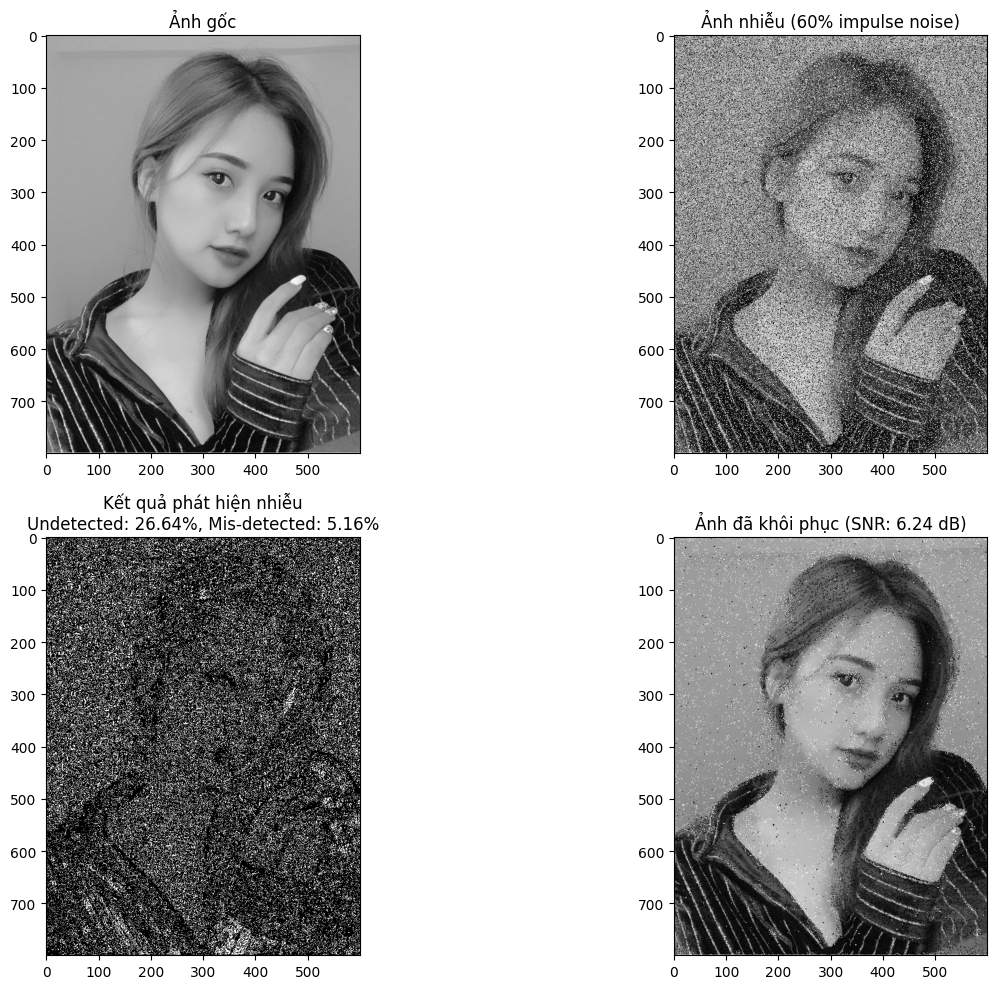

In [52]:
def main():
    # # Upload ảnh (nếu sử dụng trên Colab)
    # uploaded = files.upload()

    # # Đọc ảnh
    # filename = list(uploaded.keys())[0]
    # original = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

    import os

    # Lấy danh sách file trong thư mục 'input'
    input_dir = "inputs"
    files_in_dir = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

    if not files_in_dir:
        print("Không tìm thấy ảnh nào trong thư mục 'input'.")
        return

    # Lấy file đầu tiên trong thư mục input (hoặc bạn có thể chọn file theo ý muốn)
    filename = os.path.join(input_dir, files_in_dir[0])
    print(f"Đang sử dụng file: {filename}")

    # Đọc ảnh
    original = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)


    # Thêm nhiễu xung
    print("Thêm nhiễu xung vào ảnh...")
    noisy = add_impulse_noise(original, 0.15, 0.15)  # 60% nhiễu (30% dương + 30% âm)
    print("Đã thêm nhiễu xung.")

    # Áp dụng phương pháp phát hiện nhiễu chính xác
    print("Phát hiện nhiễu...")
    noise_flag = accurate_noise_detection(noisy)
    print("Đã phát hiện nhiễu.")

    # Khôi phục ảnh
    print("Khôi phục ảnh...")
    restored = restore_image(noisy, noise_flag)
    print("Đã khôi phục ảnh.")


    # Đánh giá kết quả
    print("Đánh giá kết quả...")
    P_undetection, P_mis_detection = evaluate_detection(original, noisy, noise_flag)
    snr = calculate_snr(original, restored)

    # Hiển thị kết quả
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Ảnh gốc')

    plt.subplot(2, 2, 2)
    plt.imshow(noisy, cmap='gray')
    plt.title('Ảnh nhiễu (60% impulse noise)')

    plt.subplot(2, 2, 3)
    plt.imshow(noise_flag, cmap='gray')
    plt.title(f'Kết quả phát hiện nhiễu\nUndetected: {P_undetection:.2f}%, Mis-detected: {P_mis_detection:.2f}%')

    plt.subplot(2, 2, 4)
    plt.imshow(restored, cmap='gray')
    plt.title(f'Ảnh đã khôi phục (SNR: {snr:.2f} dB)')

    plt.tight_layout()
    plt.show()

# Chạy chương trình chính
if __name__ == "__main__":
    main()